## Dataset preprocessing

In [ ]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = 42
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#loading the dataset
dataset = dset.CIFAR10(root="./data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
nc=3

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

#checking the availability of cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# number of gpu's available
ngpu = 1
# input noise dimension
nz = 100
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64

Random Seed:  42
Files already downloaded and verified


## DC GAN Architecture

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
            return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
#load weights to test the model
#netG.load_state_dict(torch.load('weights/netG_epoch_24.pth'))
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#load weights to test the model
#netD.load_state_dict(torch.load('weights/netD_epoch_24.pth'))
print(netD)

criterion = nn.BCELoss()

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0004, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))

fixed_noise = torch.randn(128, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Training DC GAN

In [ ]:
niter = 25
g_loss_avg = []
d_loss_avg = []

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        g_loss = []
        d_loss = []

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label.float())
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label.float())
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label.float())
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, niter, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        g_loss.append(errG.item())
        d_loss.append(errD.item())
        #save the output
        if i % 100 == 0:
            print('saving the output')
            vutils.save_image(real_cpu,'real_samples.png',normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),'fake_samples_epoch_%03d.png' % (epoch),normalize=True)

    d_loss_avg.append(np.mean(d_loss))
    g_loss_avg.append(np.mean(g_loss))

    # Check pointing for every epoch
    torch.save(netG.state_dict(), 'netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), 'netD_epoch_%d.pth' % (epoch))

Streaming output truncated to the last 5000 lines.
[12/25][133/391] Loss_D: 0.0875 Loss_G: 5.2603 D(x): 0.9253 D(G(z)): 0.0070 / 0.0080
[12/25][134/391] Loss_D: 0.0423 Loss_G: 4.4208 D(x): 0.9745 D(G(z)): 0.0160 / 0.0176
[12/25][135/391] Loss_D: 0.0851 Loss_G: 3.8862 D(x): 0.9825 D(G(z)): 0.0636 / 0.0282
[12/25][136/391] Loss_D: 0.1103 Loss_G: 4.0746 D(x): 0.9593 D(G(z)): 0.0631 / 0.0235
[12/25][137/391] Loss_D: 0.0900 Loss_G: 4.1512 D(x): 0.9603 D(G(z)): 0.0455 / 0.0214
[12/25][138/391] Loss_D: 0.0424 Loss_G: 4.8604 D(x): 0.9761 D(G(z)): 0.0171 / 0.0115
[12/25][139/391] Loss_D: 0.0693 Loss_G: 4.0240 D(x): 0.9735 D(G(z)): 0.0402 / 0.0239
[12/25][140/391] Loss_D: 0.0540 Loss_G: 4.7705 D(x): 0.9615 D(G(z)): 0.0136 / 0.0131
[12/25][141/391] Loss_D: 0.0461 Loss_G: 4.3058 D(x): 0.9770 D(G(z)): 0.0219 / 0.0186
[12/25][142/391] Loss_D: 0.1816 Loss_G: 5.1092 D(x): 0.9897 D(G(z)): 0.1476 / 0.0090
[12/25][143/391] Loss_D: 0.0835 Loss_G: 5.6275 D(x): 0.9343 D(G(z)): 0.0132 / 0.0062
[12/25][144/39

## DC GAN Architecture with SELU

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class GeneratorSELU(nn.Module):
    def __init__(self, ngpu):
        super(GeneratorSELU, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.SELU(inplace=True),  # SELU activation
            nn.AlphaDropout(p=0.2),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.SELU(inplace=True),  # SELU activation
            nn.AlphaDropout(p=0.2),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.SELU(inplace=True),  # SELU activation
            nn.AlphaDropout(p=0.2),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.SELU(inplace=True),  # SELU activation
            nn.AlphaDropout(p=0.2),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG_selu = GeneratorSELU(ngpu).to(device)
netG_selu.apply(weights_init)
#load weights to test the model
#netG.load_state_dict(torch.load('weights/netG_epoch_24.pth'))
print(netG_selu)


class DiscriminatorSELU(nn.Module):
    def __init__(self, ngpu):
        super(DiscriminatorSELU, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.SELU(inplace=True),  # SELU activation
            nn.AlphaDropout(p=0.2),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.SELU(inplace=True),  # SELU activation
            nn.AlphaDropout(p=0.2),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.SELU(inplace=True),  # SELU activation
            nn.AlphaDropout(p=0.2),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.SELU(inplace=True),  # SELU activation
            nn.AlphaDropout(p=0.2),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

netD_selu = DiscriminatorSELU(ngpu).to(device)
netD_selu.apply(weights_init)
#load weights to test the model
#netD.load_state_dict(torch.load('weights/netD_epoch_24.pth'))
print(netD_selu)

criterion = nn.BCELoss()

# setup optimizer
optimizerD_selu = optim.Adam(netD_selu.parameters(), lr=0.0004, betas=(0.5, 0.999))
optimizerG_selu = optim.Adam(netG_selu.parameters(), lr=0.0001, betas=(0.5, 0.999))

fixed_noise = torch.randn(128, nz, 1, 1, device=device)
real_label = 1
fake_label = 0



GeneratorSELU(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU(inplace=True)
    (3): AlphaDropout(p=0.2, inplace=False)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SELU(inplace=True)
    (7): AlphaDropout(p=0.2, inplace=False)
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): SELU(inplace=True)
    (11): AlphaDropout(p=0.2, inplace=False)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14):

## Training DC GAN with SELU

In [ ]:
niter = 25
g_loss_avg_2 = []
d_loss_avg_2= []

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):

        g_loss_2 = []
        d_loss_2= []

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD_selu.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD_selu(real_cpu)
        errD_real_selu = criterion(output, label.float())
        errD_real_selu.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG_selu(noise)
        label.fill_(fake_label)
        output = netD_selu(fake.detach())
        errD_fake_selu = criterion(output, label.float())
        errD_fake_selu.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real_selu + errD_fake_selu
        optimizerD_selu.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_selu.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD_selu(fake)
        errG = criterion(output, label.float())
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG_selu.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, niter, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        g_loss_2.append(errG.item())
        d_loss_2.append(errD.item())
        #save the output
        if i % 100 == 0:
            print('saving the output')
            vutils.save_image(real_cpu,'real_samples.png',normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),'fake_samples_selu_epoch_%03d.png' % (epoch),normalize=True)

    d_loss_avg_2.append(np.mean(d_loss_2))
    g_loss_avg_2.append(np.mean(g_loss_2))
    # Check pointing for every epoch
    torch.save(netG_selu.state_dict(), 'netG_selu_epoch_%d.pth' % (epoch))
    torch.save(netD_selu.state_dict(), 'netD_selu_epoch_%d.pth' % (epoch))

Streaming output truncated to the last 5000 lines.
[12/25][133/391] Loss_D: 0.1785 Loss_G: 4.8139 D(x): 0.9907 D(G(z)): 0.1335 / 0.0378
[12/25][134/391] Loss_D: 0.3652 Loss_G: 4.3879 D(x): 0.8344 D(G(z)): 0.1173 / 0.0417
[12/25][135/391] Loss_D: 0.1809 Loss_G: 3.9559 D(x): 0.9632 D(G(z)): 0.1011 / 0.0553
[12/25][136/391] Loss_D: 0.1119 Loss_G: 4.2819 D(x): 0.9806 D(G(z)): 0.0743 / 0.0444
[12/25][137/391] Loss_D: 0.4292 Loss_G: 4.4461 D(x): 0.8371 D(G(z)): 0.1659 / 0.0290
[12/25][138/391] Loss_D: 0.3808 Loss_G: 6.1243 D(x): 0.9103 D(G(z)): 0.1967 / 0.0086
[12/25][139/391] Loss_D: 1.3634 Loss_G: 0.8270 D(x): 0.4084 D(G(z)): 0.0229 / 0.5454
[12/25][140/391] Loss_D: 1.1497 Loss_G: 3.6535 D(x): 0.9826 D(G(z)): 0.5520 / 0.0703
[12/25][141/391] Loss_D: 0.3876 Loss_G: 3.0967 D(x): 0.8742 D(G(z)): 0.1549 / 0.1462
[12/25][142/391] Loss_D: 0.7015 Loss_G: 5.4281 D(x): 0.8069 D(G(z)): 0.2461 / 0.1194
[12/25][143/391] Loss_D: 1.0183 Loss_G: 3.4439 D(x): 0.5990 D(G(z)): 0.1131 / 0.1019
[12/25][144/39

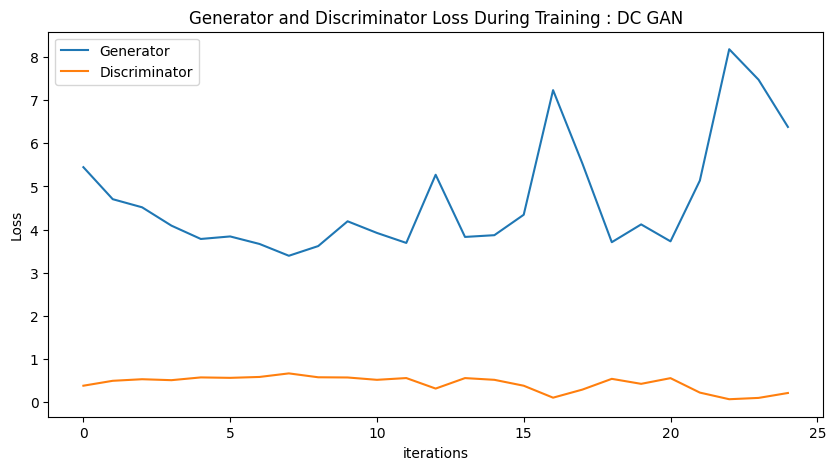

In [ ]:
# plot the loss vs epoch curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training : DC GAN")
plt.plot(g_loss_avg,label="Generator")
plt.plot(d_loss_avg,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

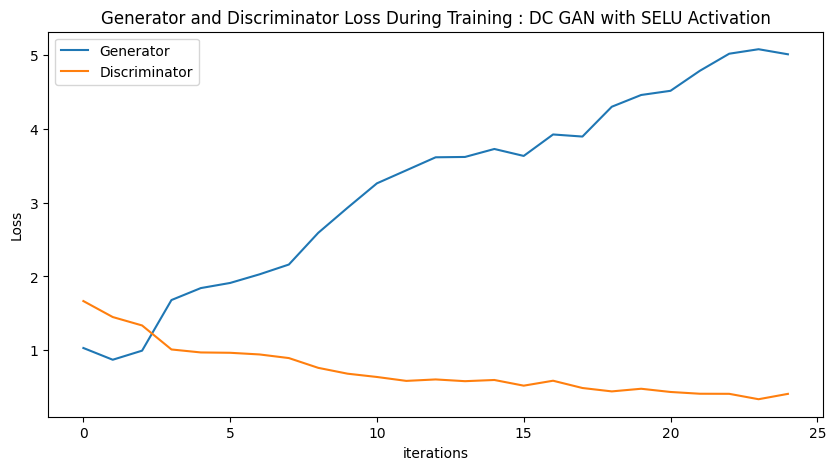

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training : DC GAN with SELU Activation")
plt.plot(g_loss_avg_2,label="Generator")
plt.plot(d_loss_avg_2,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Generating Sample Images from the DC GAN

In [ ]:
import numpy as np
#load the weights
netG.load_state_dict(torch.load('netG_epoch_24.pth'))

<All keys matched successfully>

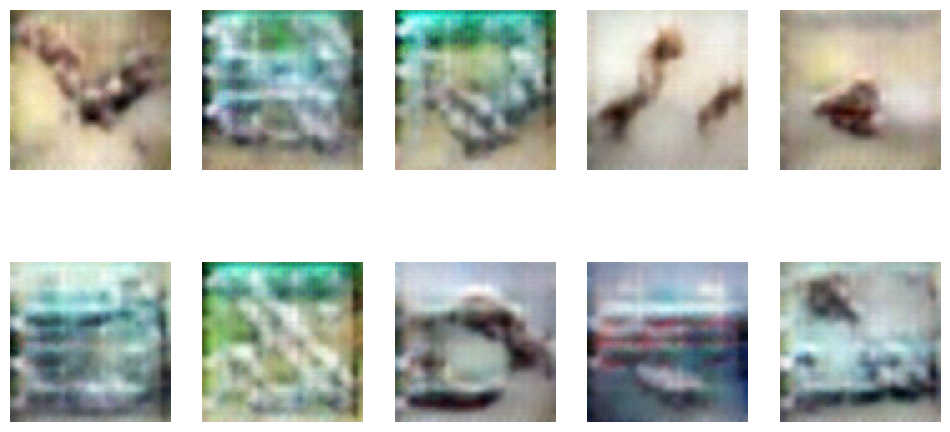

In [ ]:
netG.eval()

num = 10
images = []
import torchvision.utils as vutils
with torch.no_grad():
    for i in range(num):
        noise = torch.randn(1, nz, 1, 1, device=device)
        image = netG(noise).detach().cpu()
        images.append(image.squeeze(1))
        vutils.save_image(image, f'image_{i+1}.png', normalize=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(num):
    img = plt.imread(f"image_{i+1}.png")
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()

## Generating Sample Images from the DC GAN with SELU activation

In [ ]:
import numpy as np
#load the weights
netG_selu.load_state_dict(torch.load('netG_selu_epoch_24.pth'))

<All keys matched successfully>

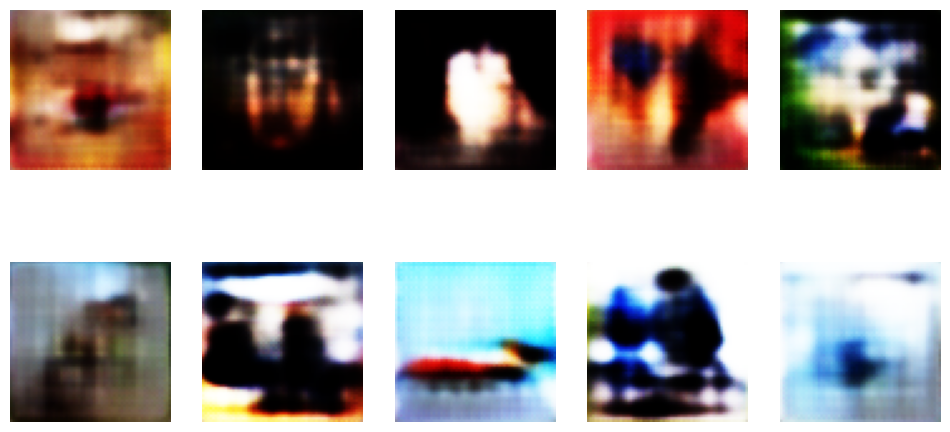

In [ ]:
netG_selu.eval()

num = 10
images_selu = []
import torchvision.utils as vutils
with torch.no_grad():
    for i in range(num):
        noise = torch.randn(1, nz, 1, 1, device=device)
        image = netG_selu(noise).detach().cpu()
        images_selu.append(image.squeeze(1))
        vutils.save_image(image, f'image_selu_{i+1}.png', normalize=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(num):
    img = plt.imread(f"image_selu_{i+1}.png")
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()

## Calculating the Inception Score to Compare the Performance of Generative models

In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=10, resize=False, splits=1):
    N = len(imgs)

    assert batch_size > 0
    assert N == batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    imgs_tensor = torch.cat(imgs, dim=0).type(dtype)
    dataloader = torch.utils.data.DataLoader(imgs_tensor, batch_size=batch_size)

    # Load Inception v3 model
    inception_model = models.inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batchv = Variable(batch)

        preds[i * batch_size:i * batch_size + batch_size] = get_pred(batchv)

    # compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)



In [ ]:
print("Calculating Inception Score...")
print(inception_score(images, cuda=True, batch_size=10, resize=True, splits=1))

Calculating Inception Score...
(2.0630253362502544, 0.0)


In [ ]:
print("Calculating Inception Score with SELU...")
print(inception_score(images_selu, cuda=True, batch_size=10, resize=True, splits=1))

Calculating Inception Score with SELU...
(2.5200016355500887, 0.0)


The DC GAN with SELU activation has a higher inception score as compared to the model without the SELU activation function. Thus SELU works better than Leaky RELU, for generative models.